In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk. stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
fake_news = pd.read_csv('fake.csv')
fake_news = fake_news[['title', 'text','site_url']]
fake_news.head()

,title,text,site_url
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup.com
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup.com
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup.com
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup.com
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup.com


In [3]:
fake_news.isnull().sum()

title       680
text         46
site_url      0
dtype: int64

#### Data Cleaning

In [4]:
fake_news['site_url'] = fake_news['site_url'].apply(lambda x:x.split('.')[0])

fake_news['title'].fillna("", inplace=True)
fake_news.dropna(inplace=True)
fake_news['type'] = 'fake'
fake_news.columns = ['title','content','publication','type']
fake_news.isnull().sum()

title          0
content        0
publication    0
type           0
dtype: int64

In [5]:
fake_news.head()

,title,content,publication,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake


In [6]:
real_news = pd.read_csv('real.csv')
real_news = real_news[['title', 'content','publication']]
real_news['type'] = 'real'
real_news.columns = ['title','content','publication','type']
real_news.head()

,title,content,publication,type
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,real
1,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",New York Times,real
2,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,New York Times,real
3,U.S. Plans to Step Up Military Campaign Agains...,"ABU DHABI, United Arab Emirates — The Obama...",New York Times,real
4,272 Slaves Were Sold to Save Georgetown. What ...,WASHINGTON — The human cargo was loaded on ...,New York Times,real


In [7]:
real_news.isnull().sum()

title          0
content        0
publication    0
type           0
dtype: int64

In [8]:
print(fake_news.shape)
print(real_news.shape)

(12953, 4)
(15712, 4)


In [9]:
df = pd.concat([fake_news, real_news])
df.reset_index(drop=True, inplace=True)
df.head()

,title,content,publication,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake


In [10]:
df.shape

(28665, 4)

In [11]:
import pickle
# save the cleaned and combined fake and real data
with open('clean_fake_real_data.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

### Text Preprocessing

In [12]:
ps = WordNetLemmatizer()

In [13]:
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', str(df['content'][i])) # removing sepcial characters and numbers
    review = review.lower() # lowering the text
    review = review.split() 
    # removing stopwords and lemmatization
    review = [ps.lemmatize(word) for word in review if not word in set(stopwords.words('english'))] 
    review = ' '.join(review)
    corpus.append(review)

all_words = []
for text in corpus:
    all_words.append(text.split())
    
words = [j for i in all_words for j in i]

from nltk.probability import FreqDist
fdist = FreqDist(words)
print(fdist)

<FreqDist with 155186 samples and 12750257 outcomes>


In [14]:
print(fdist.most_common(20))

[('trump', 105130), ('said', 92973), ('u', 62455), ('one', 61050), ('people', 58148), ('would', 57261), ('state', 53469), ('clinton', 51459), ('year', 50367), ('time', 45126), ('new', 41746), ('like', 40292), ('also', 37853), ('say', 36883), ('president', 33160), ('could', 32249), ('election', 32037), ('american', 31438), ('even', 29554), ('many', 28680)]


### Feature extraction using TF-IDF vectorizer 

In [15]:
cv = TfidfVectorizer(max_features=10000) # shape (28665, 155161)
X = cv.fit_transform(corpus).toarray()

y=pd.get_dummies(df['type'])
y=y.iloc[:,1].values

In [16]:
X.shape

(28665, 10000)

### MultinomialNB

In [17]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [18]:
# # Multinomial Naive Bayes with single train-test split
spam_detect_model = MultinomialNB().fit(X_train, y_train)

y_pred=spam_detect_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.8485958485958486


[[2020  612]
 [ 256 2845]]


              precision    recall  f1-score   support

           0       0.89      0.77      0.82      2632
           1       0.82      0.92      0.87      3101

    accuracy                           0.85      5733
   macro avg       0.86      0.84      0.85      5733
weighted avg       0.85      0.85      0.85      5733



In [19]:
# Multinomial Naive Bayes with cross validation
m = MultinomialNB()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(m, X, y, cv=kfold)
print(scores)
print(scores.mean())

[0.85071503 0.85176142 0.84931985 0.85943495 0.84827346 0.85833915
 0.84612701 0.85066294 0.8611305  0.85659456]
0.8532358860883198


In [28]:
# Multinomial Naive Bayes with cross validation and GridSearchCV
param_grid = {'alpha': [1, 1e-2, 1e-3, 1e-10]}

m = MultinomialNB()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(m, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')


Train Accuracy : 0.8581022152450724
{'alpha': 1e-10}
MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)
Test Accuracy : 0.8550497121925693 



## Logistic Regression

In [22]:
# With single train test split
clf = LogisticRegression(solver='sag').fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.9195883481597767


[[2365  267]
 [ 194 2907]]


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2632
           1       0.92      0.94      0.93      3101

    accuracy                           0.92      5733
   macro avg       0.92      0.92      0.92      5733
weighted avg       0.92      0.92      0.92      5733



In [23]:
# Logistic with cross validation
logreg = LogisticRegression(solver='sag')
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(logreg, X, y, cv=kfold)
print(scores)
print(scores.mean())

[0.92256714 0.92396233 0.92884548 0.93617021 0.91942797 0.92951849
 0.93091417 0.92742498 0.91800419 0.93300768]
0.9269842647193769


In [29]:
# Logistic with cross validation and GridSearchCV

param_grid = [{'C': [0.1, 1, 10, 100],
                'penalty': ['l1','l2']  
             }]

m = LogisticRegression(solver='liblinear')
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(m, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

Train Accuracy : 0.9366387580673295
{'C': 10, 'penalty': 'l1'}
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Test Accuracy : 0.9370312227455084 



### Random Forests

In [30]:
#Random Forest with singal train-test split
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
m.fit(X_train, y_train)

predictions = m.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.92      0.80      0.85      2632
           1       0.84      0.94      0.89      3101

    accuracy                           0.87      5733
   macro avg       0.88      0.87      0.87      5733
weighted avg       0.88      0.87      0.87      5733

Accuracy : 0.8728414442700158 



In [32]:
# Random Forest with cross validation and grid search
param_grid = [{'n_estimators':[30, 40], 
               'max_features':[4,6]}]

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(m, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)

print("Train Accuracy :",grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

predictions = grid_search.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

Train Accuracy : 0.8017617303331589
{'max_features': 6, 'n_estimators': 30}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Test Accuracy : 0.792778649921507 



### ROC AUC Curve

In [33]:
classifiers = [LogisticRegression(solver='sag'), 
               MultinomialNB(),
              RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

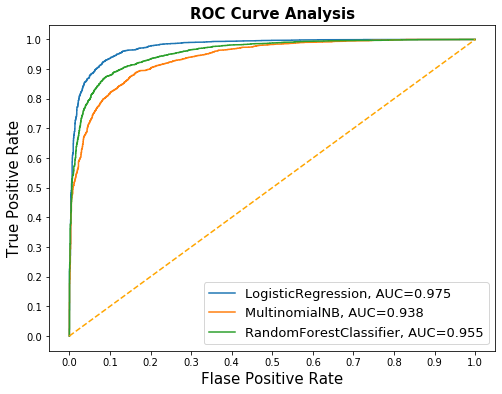

In [34]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()